In [10]:
import time, math, sys
from itertools import cycle
import numpy as np
import matplotlib.pyplot as plt
import deepxde as dde
import torch

In [11]:
dde.backend.set_default_backend("pytorch")
torch.manual_seed(42)
np.random.seed(42)

Setting the default backend to "pytorch". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


In [12]:
_COL = cycle(["\033[96m", "\033[92m", "\033[93m", "\033[95m"])
def cprint(txt):
    print(f"{next(_COL)}{txt}\033[0m"); sys.stdout.flush()

In [13]:
def u_exact(x, t, L=1.0, n_max=120):
    V = t / L + L / 3
    for n in range(1, n_max + 1):
        V -= (
            2 * L / (np.pi**2 * n**2)
            * np.exp(-np.pi**2 * n**2 * t / L**2)
            * np.cos(np.pi * n * x / L)
        )
    return -2 + 2 * np.sqrt(-x + x**2 / (2 * L) + 1 + V)

In [14]:
L, T = 1.0, 2.0
geom       = dde.geometry.Interval(0, L)
timedomain = dde.geometry.TimeDomain(0, T)
geomtime   = dde.geometry.GeometryXTime(geom, timedomain)

In [15]:
def pde(x, u):
    u_t = dde.grad.jacobian(u, x, i=0, j=1)
    u_x = dde.grad.jacobian(u, x, i=0, j=0)
    k   = 1 + u/2
    return k * u_t - dde.grad.jacobian(k * u_x, x, i=0, j=0)

def bc_left (x, on_b): return on_b and np.isclose(x[0], 0. ) and not np.isclose(x[1], 0.)
def bc_right(x, on_b): return on_b and np.isclose(x[0], L  ) and not np.isclose(x[1], 0.)

robin_left  = dde.icbc.RobinBC(geomtime, lambda x,u: 1./(1+u/2), bc_left,  0)
robin_right = dde.icbc.RobinBC(geomtime, lambda x,u: 0.,         bc_right, 0)
ic          = dde.icbc.IC    (geomtime, lambda x: 0.,            lambda _,on_i: on_i, 0)

In [16]:
def run_pinn(N_dom, hidden=50, layers=6):
    cprint(f"    • building collocation set (N_dom = {N_dom})")
    N_bdry = int(round(0.15 * N_dom))
    N_init = N_bdry

    data = dde.data.TimePDE(
        geomtime,
        pde,
        [robin_left, robin_right, ic],
        num_domain   = N_dom,
        num_boundary = N_bdry,
        num_initial  = N_init,
        train_distribution = "LHS",   # Latin–hyper-cube → exact count, no duplicates
    )

    net   = dde.nn.FNN([2] + [hidden]*layers + [1], "tanh", "Glorot normal")
    model = dde.Model(data, net)

    # --- Adam phase ----------------------------------------------------
    cprint("       Adam  (15 000 iters, lr = 1e-3)")
    resamplers = (
        [dde.callbacks.PDEPointResampler(period=100)]
        if hasattr(dde.callbacks, "PDEPointResampler") else []
    )
    model.compile("adam", lr=1e-3)
    model.train(iterations=5_000, callbacks=resamplers, display_every=5000)

    # --- L-BFGS refinement -------------------------------------------
    cprint("       L-BFGS refinement")
    model.compile("L-BFGS")
    model.train()

    # --- error on reference grid -------------------------------------
    cprint("       computing L2 error")
    x_ref, t_ref = np.linspace(0, L, 401), np.linspace(0, T, 401)
    X, TT = np.meshgrid(x_ref, t_ref, indexing="ij")
    XT    = np.vstack([X.ravel(), TT.ravel()]).T
    err   = np.sqrt(np.mean((model.predict(XT)[:,0] - u_exact(XT[:,0], XT[:,1]))**2))

    h_tilde = math.sqrt((L*T) / N_dom)
    return h_tilde, err

In [17]:
levels = 10
N_min, N_max = 100, 5000

step = (N_max - N_min) / (levels - 1)

N_list = [int(round((N_min + i * step) / 16) * 16) for i in range(levels)]

print(N_list)

[96, 448, 800, 1152, 1504, 1856, 2208, 2544, 2896, 3248, 3600, 3952, 4304, 4656, 4992]


In [18]:
hs, errs, times = [], [], []
for k, N in enumerate(N_list, 1):
    cprint(f"\n========= Level {k}/{levels} — interior points {N} =========")
    t0 = time.perf_counter()
    h, e = run_pinn(N)
    dt   = time.perf_counter() - t0
    hs.append(N); errs.append(e); times.append(dt) #so there the step is we have N -- number of collocation points inside.
    cprint(f"    ✓ done   h̃={h:.2e},  L2={e:.3e},  time={dt/60:.1f} min")


========= Level 1/15 — interior points 96 =========
    • building collocation set (N_dom = 96)
       Adam  (15 000 iters, lr = 1e-3)
Compiling model...
'compile' took 0.000180 s

Training model...

0         [4.74e-02, 1.37e+00, 2.82e-02, 2.66e-02]    [4.74e-02, 1.37e+00, 2.82e-02, 2.66e-02]    []  
5000      [8.74e-06, 1.57e-07, 3.83e-06, 2.82e-05]    [1.84e-05, 1.57e-07, 3.83e-06, 2.82e-05]    []  

Best model at step 5000:
  train loss: 4.09e-05
  test loss: 5.05e-05
  test metric: []

'train' took 42.415430 s

       L-BFGS refinement
Compiling model...
'compile' took 0.000808 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
5000      [7.88e-05, 1.57e-07, 3.83e-06, 2.82e-05]    [1.84e-05, 1.57e-07, 3.83e-06, 2.82e-05]    []  
5555      [7.18e-07, 3.30e-08, 2.89e-08, 1.08e-07]    [8.23e-05, 3.30e-08, 2.89e-08, 1.08e-07]    []  

Best model at step 5555:
  train loss: 8.88e-07
  test loss: 8.25e-05



Observed convergence order  p ≈ -0.99


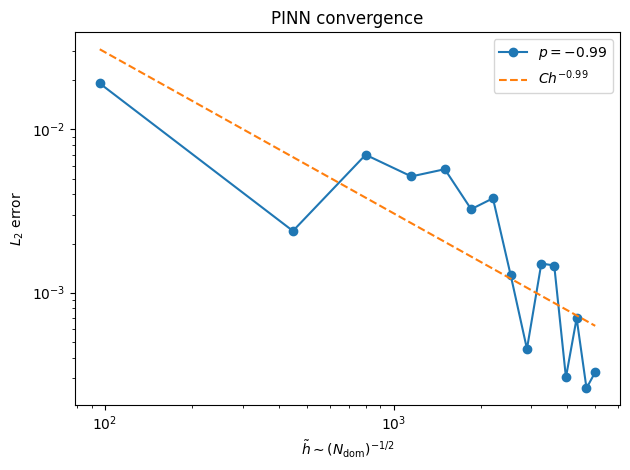

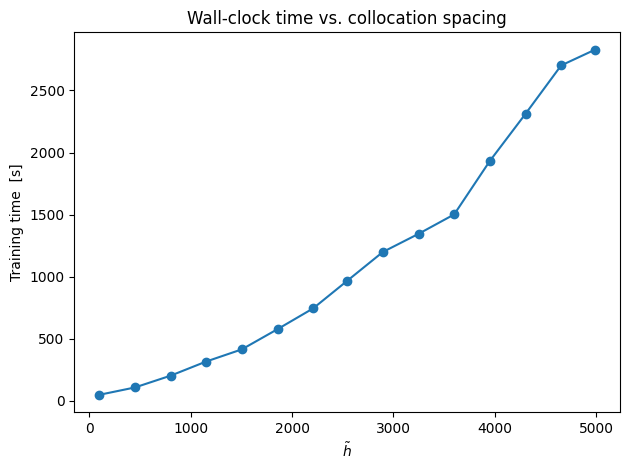

In [19]:
hs, errs, times = map(np.array, (hs, errs, times))
p, logC = np.polyfit(np.log(hs), np.log(errs), 1)
C = math.exp(logC)
print(f"\nObserved convergence order  p ≈ {p:.2f}")

plt.figure()
plt.loglog(hs, errs, "o-", label=fr"$p={p:.2f}$")
plt.loglog(hs, C*hs**p, "--", label=rf"$Ch^{{{p:.2f}}}$")
plt.xlabel(r"$\tilde h \sim (N_{\rm dom})^{-1/2}$");  plt.ylabel(r"$L_2$ error")
plt.title("PINN convergence"); plt.legend(); plt.tight_layout()

plt.figure()
plt.plot(hs, times, "o-")
plt.xlabel(r"$\tilde h$");   plt.ylabel("Training time  [s]")
plt.title("Wall-clock time vs. collocation spacing"); plt.tight_layout()

plt.show()